# Toydata

In [1]:
import os
from typing import NamedTuple
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from tools.preferences import kwarg_savefig
from tools.preprocessing import get_quantiles, filter_pipeline
from tools.go import top_degs, get_deg, go_plot

In [2]:
from grnet.toydata import load_dataset

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
class Config(NamedTuple):
    data: ad.AnnData = ad.AnnData(load_dataset("prototype1"))
    export: str = "/home/jovyan/output/toydata"
    dsname: str = ""
    
conf = Config()
os.makedirs(conf.export, exist_ok=True)

In [5]:
conf.data.var.index = [
    f"${'_{'.join(v.split('_')) + '}'}$" for v in conf.data.var.index
]

In [6]:
sc.pp.filter_cells(conf.data, min_genes=200)
sc.pp.filter_genes(conf.data, min_cells=3)
conf.data.uns["dsname"] = conf.dsname

In [7]:
conf.data

AnnData object with n_obs × n_vars = 1000 × 10000
    obs: 'n_genes'
    var: 'n_cells'
    uns: 'dsname'

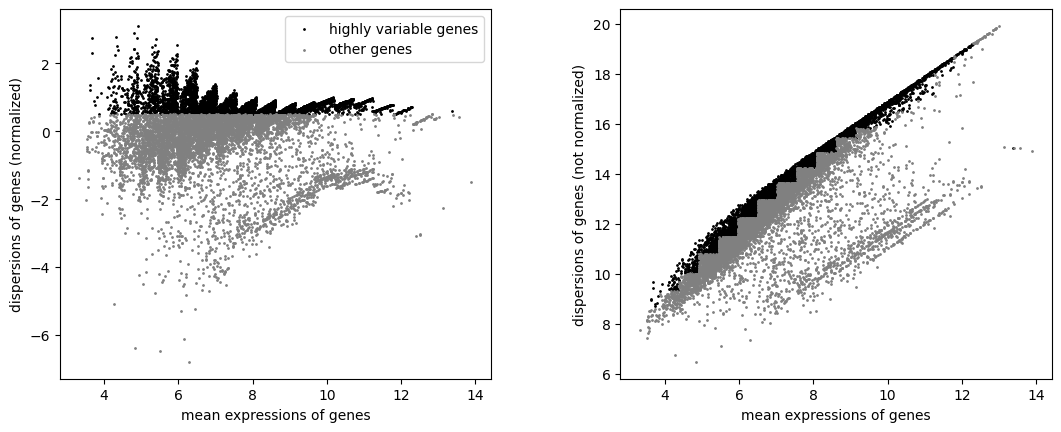

In [8]:
sc.pp.highly_variable_genes(conf.data, min_mean=0.0125, max_mean=15, min_disp=0.5)
sc.pl.highly_variable_genes(conf.data)

In [9]:
sc.tl.pca(conf.data, svd_solver='arpack')

In [10]:
sc.pp.neighbors(conf.data, n_pcs=50)

In [11]:
sc.tl.umap(conf.data)

In [12]:
sc.tl.leiden(conf.data, resolution=.5)

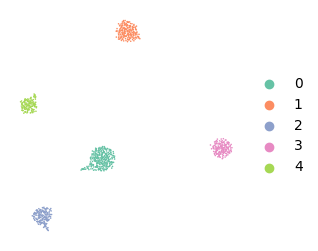

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(
    conf.data, color="leiden", ax=ax, 
    size=5, show=False, palette=[plt.cm.Set2(i) for i in range(5)]
)
ax.axis("off");
ax.set(title=f"{conf.dsname}", xlabel="UMAP1", ylabel="UMAP2");

In [14]:
newnames = [
    f"Cluster-{v}" for v in ["A", "B", "C", "D", "E"]
]
conf.data.rename_categories("leiden", newnames)

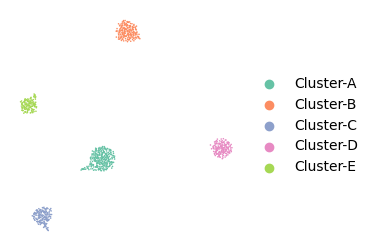

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(
    conf.data, color="leiden", ax=ax, 
    size=5, show=False, palette=[plt.cm.Set2(i) for i in range(5)]
)
ax.axis("off");
ax.set(title=f"{conf.dsname}", xlabel="UMAP1", ylabel="UMAP2");

fig.savefig(f"{conf.export}/umap.png", **kwarg_savefig)

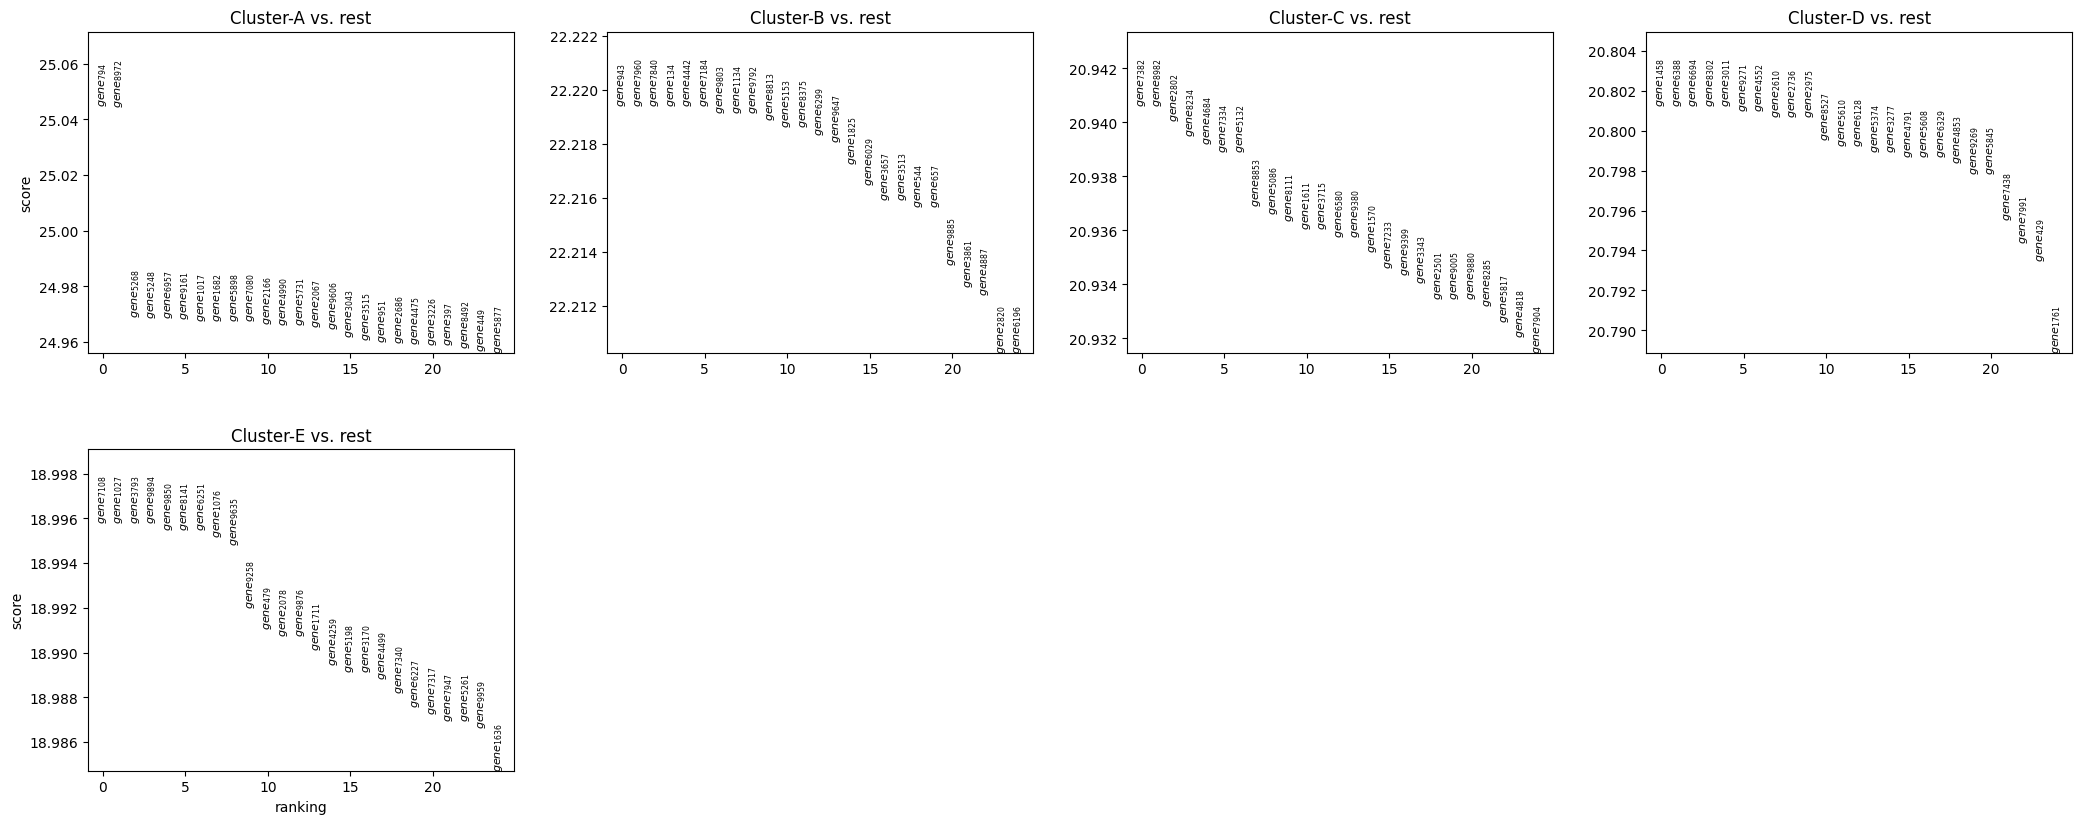

In [16]:
sc.tl.rank_genes_groups(conf.data, "leiden", method='wilcoxon')
sc.pl.rank_genes_groups(conf.data, n_genes=25, sharey=False)

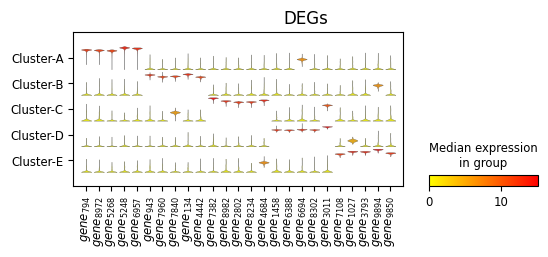

In [17]:
n = 5

fig, ax = plt.subplots(figsize=(6, 2))
sc.pl.stacked_violin(
    conf.data, top_degs(conf.data, n, min_logfc=1),
    groupby="leiden", cmap="autumn_r", 
    ax=ax, show=False, figsize=(6, 2)
)
ax.set_title("DEGs")

fig.savefig(
    f"{conf.export}/sigup_violin.png",
    **kwarg_savefig
)

In [18]:
from grnet.clusters import CellClasses
from grnet.models import PC, PretrainedModel
from grnet.plot import grnplot, planetplot

In [19]:
lst_data = [
    [
        conf.data[
            conf.data.obs["leiden"] == cluster_id,
            get_deg(conf.data, name, min_logfc=1)[:5]
        ] for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
    ] for name in conf.data.uns["rank_genes_groups"]["names"].dtype.names
]

In [20]:
models = [
    PC(lst_data[i // 5][i % 5].to_df()) for i in range(5 ** 2)
]

for m in models:
    m.estimate()

Text(0.5, 0.95, 'GRNs')

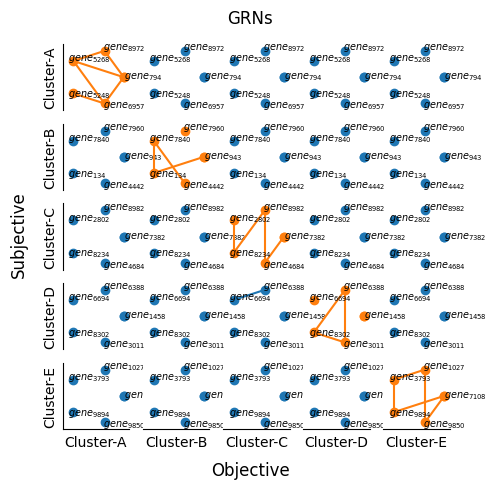

In [21]:
fig, ax = plt.subplots(5, 5, figsize=(5, 5))

for (i, m), a in zip(enumerate(models), ax.ravel()):
    grnplot(m, ax=a, color="C1" if i // 5 == i % 5 else "C0")
    names = conf.data.uns["rank_genes_groups"]["names"].dtype.names
    a.spines['left'].set_visible(i % 5 == 0)
    a.spines['bottom'].set_visible(i // 5 == 4)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params(
        axis='both', which='both', 
        bottom=False, top=False, left=False, right=False, 
        labelbottom=False, labelleft=False
    )
    a.axis("on") if (i // 5 == 4) | (i % 5 == 0) else None
    a.set(
        xlabel=names[i % 5] if i // 5 == 4 else "",
        ylabel=names[i // 5] if i % 5 == 0 else ""
    )
fig.supylabel("Subjective", x=.02)
fig.supxlabel("Objective", y=.01)
fig.suptitle("GRNs", y=.95)

# fig.savefig(f"{conf.export}/grns.png", **kwarg_savefig)

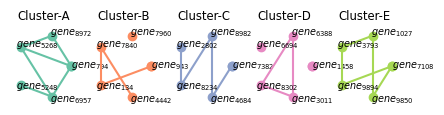

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(5, 1))

for (i, m), a in zip(
    enumerate([v for i, v in enumerate(models) if i // 5 == i % 5]), 
    ax.ravel()
):
    grnplot(m, ax=a, color=plt.cm.Set2(i))
    names = conf.data.uns["rank_genes_groups"]["names"].dtype.names
    a.set_title(names[i], fontsize="small")

fig.savefig(f"{conf.export}/grns.png", **kwarg_savefig)

In [23]:
from grnet.evaluations import d_asterisk

In [24]:
metric_matrix = pd.DataFrame(
    np.array(
        [d_asterisk(
            models[5 * (i // 5) + (i // 5)].get_matrix(), 
            models[i].get_matrix()
        ) for i in range(5 ** 2)]
    ).reshape(5, 5),
    index=conf.data.uns["rank_genes_groups"]["names"].dtype.names,
    columns=conf.data.uns["rank_genes_groups"]["names"].dtype.names
)

In [25]:
import seaborn as sns

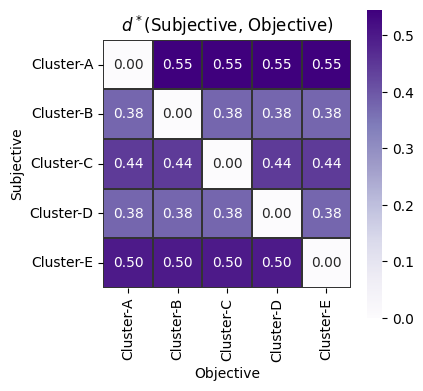

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    data=metric_matrix,
    square=True, vmin=0,
    annot=True, fmt=".2f",
    cmap="Purples", ax=ax,
    linewidth=.1, linecolor=".2"
)

ax.set(
    ylabel="Subjective", 
    xlabel="Objective", 
    title="$d^*$" + "(Subjective, Objective)"
);

fig.savefig(f"{conf.export}/dasterisk.png", **kwarg_savefig)

In [27]:
conf2 = Config(data=ad.AnnData(load_dataset("prototype2")))

In [28]:
conf2.data.var.index = [
    f"${'_{'.join(v.split('_')) + '}'}$" for v in conf2.data.var.index
]

In [29]:
sc.pp.filter_cells(conf2.data, min_genes=200)
sc.pp.filter_genes(conf2.data, min_cells=3)
conf2.data.uns["dsname"] = conf2.dsname

In [30]:
conf2.data

AnnData object with n_obs × n_vars = 1500 × 10000
    obs: 'n_genes'
    var: 'n_cells'
    uns: 'dsname'

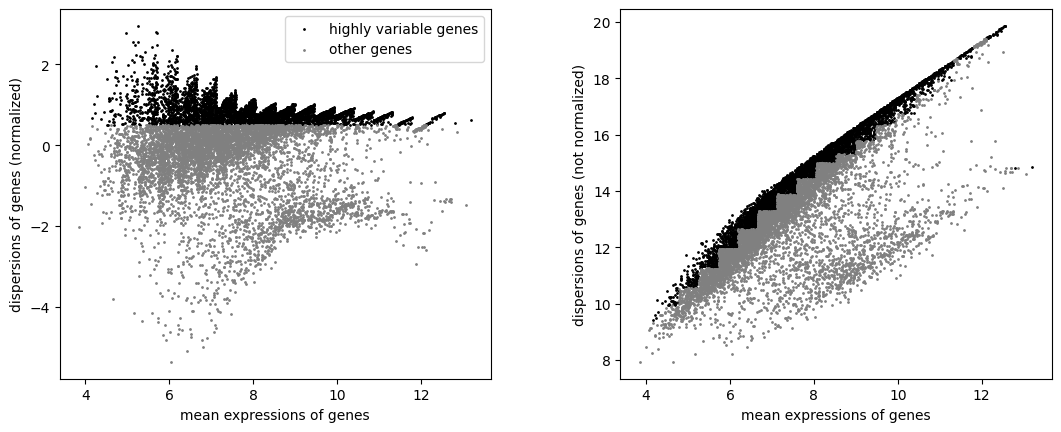

In [31]:
sc.pp.highly_variable_genes(conf2.data, min_mean=0.0125, max_mean=15, min_disp=0.5)
sc.pl.highly_variable_genes(conf2.data)

In [32]:
sc.tl.pca(conf2.data, svd_solver='arpack')

In [33]:
sc.pp.neighbors(conf2.data, n_pcs=50)

In [34]:
sc.tl.umap(conf2.data)

In [35]:
sc.tl.leiden(conf2.data, resolution=.5)

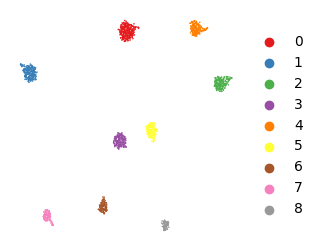

In [36]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(
    conf2.data, color="leiden", ax=ax, 
    size=5, show=False, palette="Set1"
)
ax.axis("off");
ax.set(title=f"{conf2.dsname}", xlabel="UMAP1", ylabel="UMAP2");

In [37]:
newnames2 = [
    f"Cluster-{v}" for v in ["R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
]
conf2.data.rename_categories("leiden", newnames2)

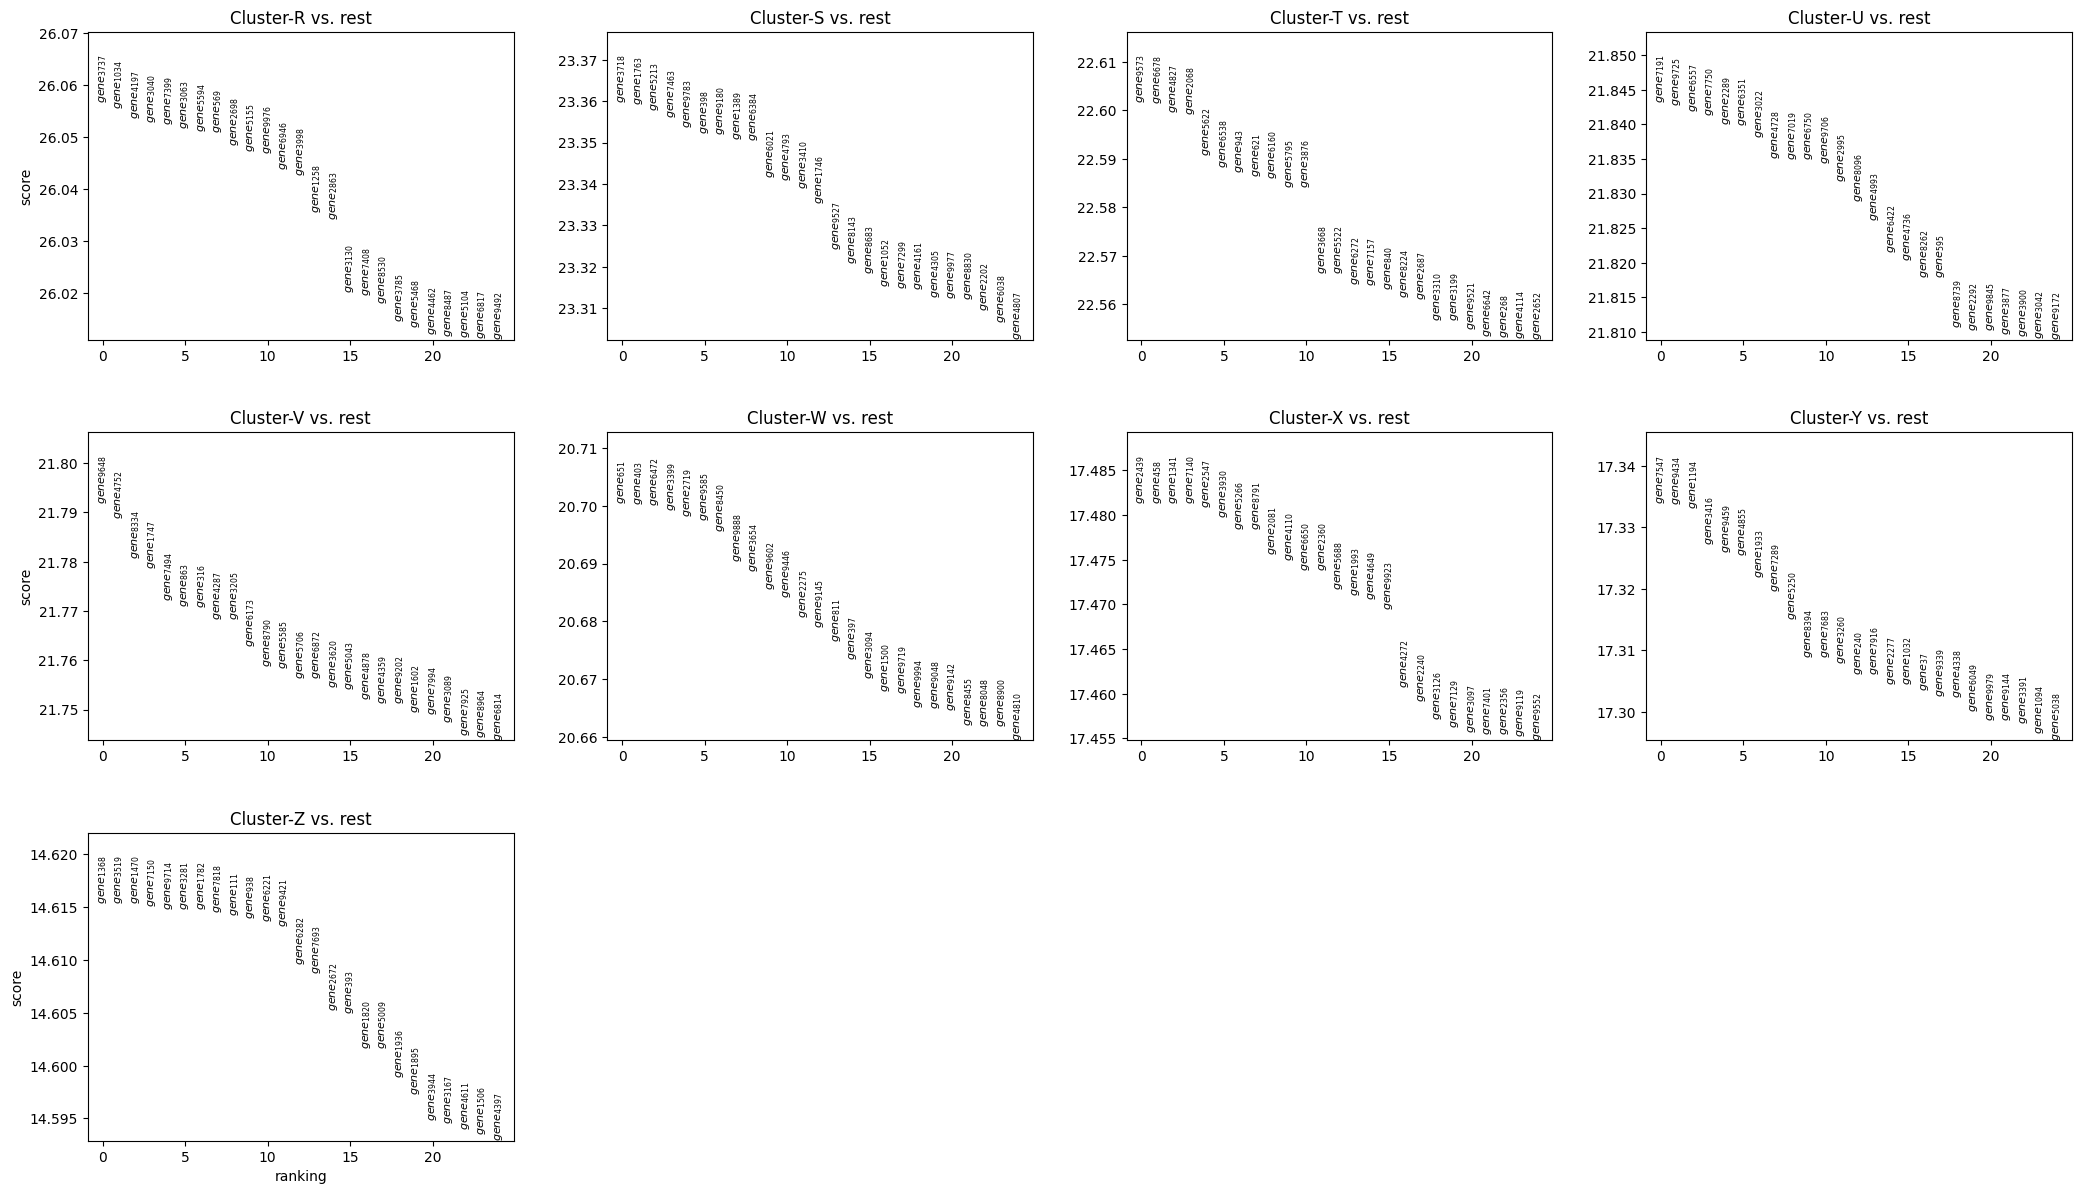

In [38]:
sc.tl.rank_genes_groups(conf2.data, "leiden", method='wilcoxon')
sc.pl.rank_genes_groups(conf2.data, n_genes=25, sharey=False)

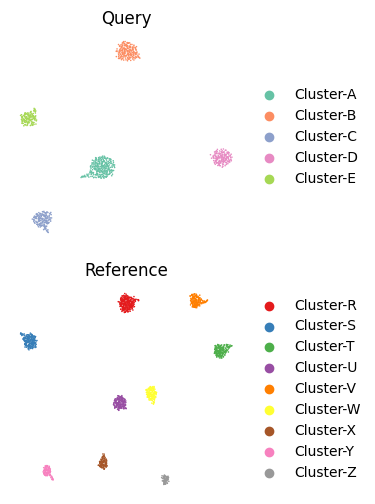

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(3, 6))

for a, d, title in zip(
    ax, 
    [conf.data, conf2.data],
    ["Query", "Reference"]
):
    n = len(d.uns["rank_genes_groups"]["names"].dtype.names)
    sc.pl.umap(
        d, color="leiden", ax=a, 
        size=5, show=False, 
        # legend_loc="on data",
        palette=[
            plt.cm.Set2(i) for i in range(n)
        ] if n == 5 else [
            plt.cm.Set1(i) for i in range(n)
        ]
    )
    a.axis("off");
    a.set(title=title, xlabel="UMAP1", ylabel="UMAP2");

fig.savefig(f"{conf.export}/query&reference.png", **kwarg_savefig)

In [40]:
lst_data2 = [
    [
        conf2.data[
            conf2.data.obs["leiden"] == cluster_id,
            get_deg(conf2.data, name, min_logfc=1)[:5]
        ] for cluster_id in conf2.data.uns["rank_genes_groups"]["names"].dtype.names
    ] for name in conf2.data.uns["rank_genes_groups"]["names"].dtype.names
]

models2 = [
    PC(lst_data2[i // 9][i % 9].to_df()) for i in range(9 ** 2)
]

for m in models2:
    m.estimate()

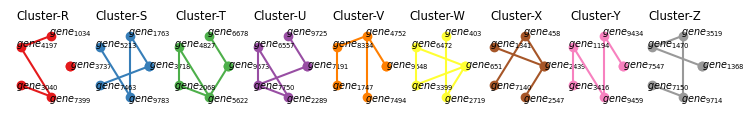

In [41]:
fig, ax = plt.subplots(1, 9, figsize=(9, 1))

for (i, m), a in zip(
    enumerate([v for i, v in enumerate(models2) if i // 9 == i % 9]), 
    ax.ravel()
):
    grnplot(m, ax=a, color=plt.cm.Set1(i))
    names = conf2.data.uns["rank_genes_groups"]["names"].dtype.names
    a.set_title(names[i], fontsize="small")

fig.savefig(f"{conf.export}/reference.png", **kwarg_savefig)

In [42]:
key = "Cluster-C"

ds_q2r = [
    conf.data[
        conf.data.obs["leiden"] == cluster_id,
        get_deg(conf.data, key, min_logfc=1)[:5]
    ] for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
] + [
    conf2.data[
        conf2.data.obs["leiden"] == cluster_id,
        get_deg(conf.data, key, min_logfc=1)[:5]
    ] for cluster_id in conf2.data.uns["rank_genes_groups"]["names"].dtype.names
]

models_q2r = [
    PC(d.to_df()) for d in ds_q2r
]

for m in models_q2r:
    m.estimate()

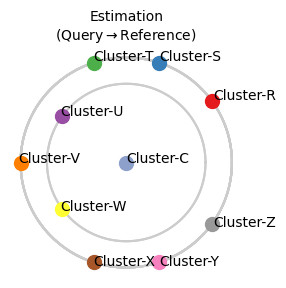

In [43]:
fig, ax = plt.subplots(figsize=(3, 3))

q_q2r = CellClasses(
    models=models_q2r[:5],
    names=newnames,
    colors=[plt.cm.Set2(i) for i in range(5)]
)

r_q2r = CellClasses(
    models=models_q2r[5:],
    names=newnames2,
    colors="Set1"
)

ax.axis("off")
ax.set_title(
    "Estimation\n(Query" + r"$\rightarrow$" + "Reference)",
    fontsize="medium"
) 

planetplot(subjective=q_q2r, objective=r_q2r, id=2, s=100, ax=ax)

fig.savefig(f"{conf.export}/q2r.png", **kwarg_savefig)

In [44]:
key = "Cluster-U"

ds_r2q = [
    conf.data[
        conf.data.obs["leiden"] == cluster_id,
        get_deg(conf2.data, key, min_logfc=1)[:5]
    ] for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
] + [
    conf2.data[
        conf2.data.obs["leiden"] == cluster_id,
        get_deg(conf2.data, key, min_logfc=1)[:5]
    ] for cluster_id in conf2.data.uns["rank_genes_groups"]["names"].dtype.names
]

models_r2q = [
    PC(d.to_df()) for d in ds_r2q
]

for m in models_r2q:
    m.estimate()

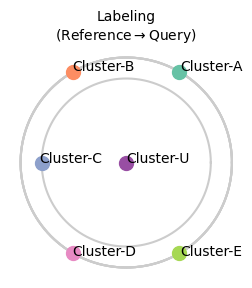

In [45]:
fig, ax = plt.subplots(figsize=(3, 3))

q_r2q = CellClasses(
    models=models_r2q[:5],
    names=newnames,
    colors=[plt.cm.Set2(i) for i in range(5)]
)

r_r2q = CellClasses(
    models=models_r2q[5:],
    names=newnames2,
    colors="Set1"
)

ax.axis("off")
ax.set_title(
    "Labeling\n(Reference" + r"$\rightarrow$" + "Query)",
    fontsize="medium"
) 

planetplot(subjective=r_r2q, objective=q_r2q, id=3, s=100, ax=ax)

fig.savefig(f"{conf.export}/r2q.png", **kwarg_savefig)

# ML model

In [64]:
import optuna, lightgbm, shap

In [74]:
import optuna.integration.lightgbm as lgb
import lightgbm as lgbm

from sklearn.model_selection import train_test_split

In [121]:
def encoder(series: pd.Series) -> pd.Series:
    conversion_dict = {
        v: i for i, v in enumerate(series.unique())
    }
    return pd.Series(
        [conversion_dict[v] for v in series],
        series.index
    )

In [243]:
x_tr, x_te, y_tr, y_te = train_test_split(
    load_dataset("prototype1"), 
    encoder(conf.data.obs["leiden"]),
    test_size=.2,
    random_state=0
)

x_tr, x_v, y_tr, y_v = train_test_split(
    x_tr, y_tr,
    test_size=.25,
    random_state=0
)

train = lgbm.Dataset(x_tr, y_tr)
valid = lgbm.Dataset(x_v, y_v)
test = lgbm.Dataset(x_te, y_te)

# params = dict(
#     objective="binary", metric="binary_logloss",
#     verbosity=-1, deterministic=True,
#     random_seed=0, num_boost_round=100,
#     force_col_wise=True
# )

params = dict(
    objective="multiclass", 
    metric="multi_logloss",
    num_class=conf.data.obs["leiden"].unique().size,
    verbosity=-1, deterministic=True,
    random_seed=0, num_boost_round=100,
    force_col_wise=True
)

In [244]:
model = lgb.LightGBMTuner(
    params, train,
    valid_sets=valid,
    optuna_seed=0,
    verbosity=-1,
    callbacks=[lgbm.early_stopping(50), lgbm.log_evaluation(1000)]
)

In [245]:
%%capture
model.run()

In [246]:
tuned = model.get_best_booster()

In [247]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, roc_auc_score, 
    precision_recall_curve, 
    average_precision_score
)

In [248]:
class roc_multi():
    def __init__(self, model, x, y):
        self.x = [
            roc_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.y = [
            roc_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.thresh = [
            roc_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.auc = [
            roc_auc_score(y[:, i], model.predict(x)[:, i], multi_class='ovr') for i in range(y.shape[1])
        ]

In [249]:
def plot_roc(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    roc = roc_multi(model, x, y)
    ax = ax.ravel()
    
    for (i, x_), y_, auc, label in zip(enumerate(roc.x), roc.y, roc.auc, label_dict):
        ax[i].plot(x_, y_, label=f"{label} (AUC:{auc.round(3)})", c=eval(f"plt.cm.{cmap}")(i/len(roc.auc)))
    
    ax[-1].plot(
        [0] + np.linspace(0, 1, 100).tolist(), 
        [0] + np.stack([
            np.interp(np.linspace(0, 1, 100), x, y) for x, y in zip(roc.x, roc.y)
        ]).mean(axis=0).tolist(),
        c="r",
        label=f"macro (AUC:{np.array(roc.auc).mean().round(3)})"
    )
    ax[-1].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 0, 1], [0, 1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=0) for sp in ax]
    [sp.plot([0, 1], [0, 1], c="gray", label="baseline", zorder=1, alpha=0.5) for sp in ax]
    [sp.set(xlabel="false positive rate", ylabel="true positive rate", title="ROC curve (OvR)") for sp in ax] 
    [sp.legend(fontsize="small") for sp in ax]

In [250]:
label_bin = label_binarize(
    conf.data.obs["leiden"][y_te.index],
    classes = conf.data.obs["leiden"].unique()
)

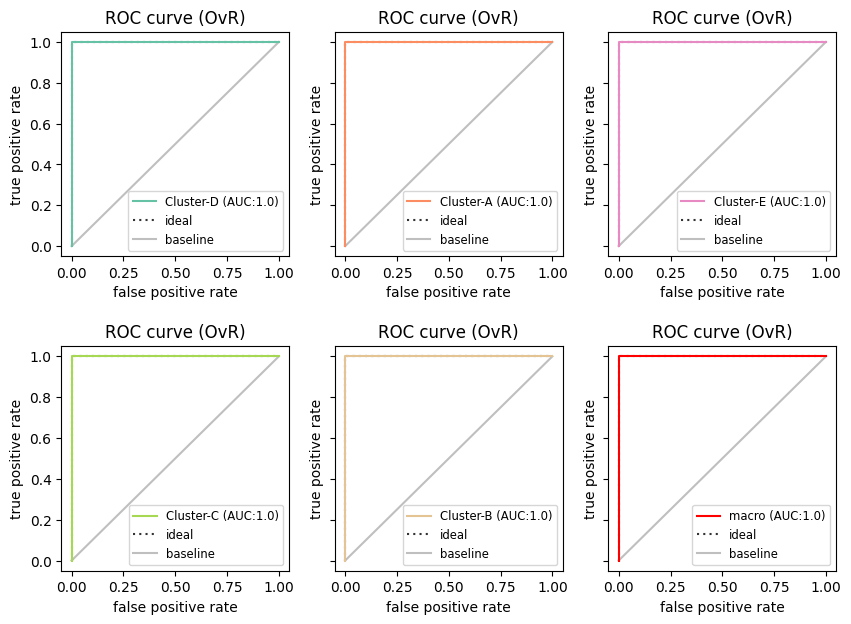

In [295]:
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(10, 7))
plt.subplots_adjust(hspace=.4)

plot_roc(
    tuned, x_te, label_bin, 
    ax, cmap="Set2",
    label_dict={v: i for i, v in enumerate(conf.data.obs["leiden"].unique())}
)

In [252]:
class pr_multi():
    def __init__(self, model, x, y):
        self.x = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.y = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.thresh = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.ap = [
            average_precision_score(y[:, i], model.predict(x)[:, i]) for i in range(y.shape[1])
        ]
        self.base = [len(y[:, i][y[:, i] == 1]) / len(y) for i in range(y.shape[1])]

In [253]:
def plot_pr(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    pr = pr_multi(model, x, y)
    ax = ax.ravel()
    
    for (i, x_), y_, ap, label, base in zip(enumerate(pr.x), pr.y, pr.ap, label_dict, pr.base):
        ax[i].plot(x_, y_, label=f"{label} (AP:{ap.round(3)})", c=eval(f"plt.cm.{cmap}")(i/len(pr.ap)))
        ax[i].plot([0, 1], [base, base], c="gray", label="baseline", zorder=1, alpha=0.5)
    
    p_avg, r_avg, thr_avg = precision_recall_curve(y.ravel(), model.predict(x).ravel())
    
    ax[-1].plot(
        r_avg, p_avg, c="r", label=f"micro (AP:{average_precision_score(y, model.predict(x)).round(3)})"
    )
    base = np.array(pr.base).mean()
    ax[-1].plot([0, 1], [base, base], c="gray", label="baseline", zorder=1, alpha=0.5)
    ax[-1].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 1], [1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=2) for sp in ax]
    [sp.set(xlabel="recall", ylabel="precision", title="PR curve (OvR)") for sp in ax] 
    [sp.legend(fontsize="small") for sp in ax]

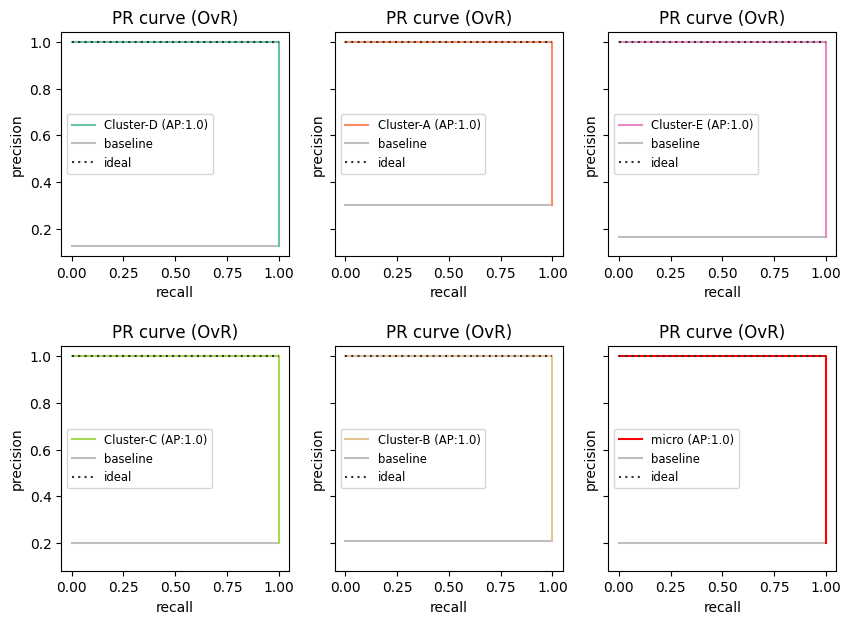

In [296]:
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(10, 7))
plt.subplots_adjust(hspace=.4)

plot_pr(
    tuned, x_te, label_bin, 
    ax, cmap="Set2",
    label_dict={v: i for i, v in enumerate(conf.data.obs["leiden"].unique())}
)

In [255]:
shap.initjs()

In [287]:
x_te.columns = [
    f"${'_{'.join(v.split('_')) + '}'}$" for v in x_te.columns
]

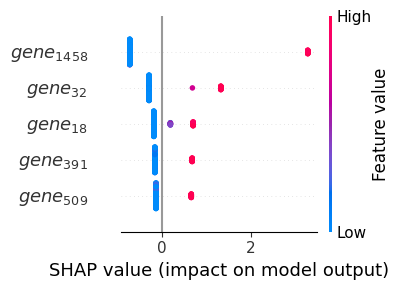

In [294]:
explainer = shap.TreeExplainer(model=tuned)
shap_values = explainer.shap_values(X=x_te)

shap.summary_plot(
    shap_values[0], x_te, 
    max_display=5, show=False,
    plot_size=(4, 3)
)

plt.savefig(f"{conf.export}/shap.png", **kwarg_savefig)

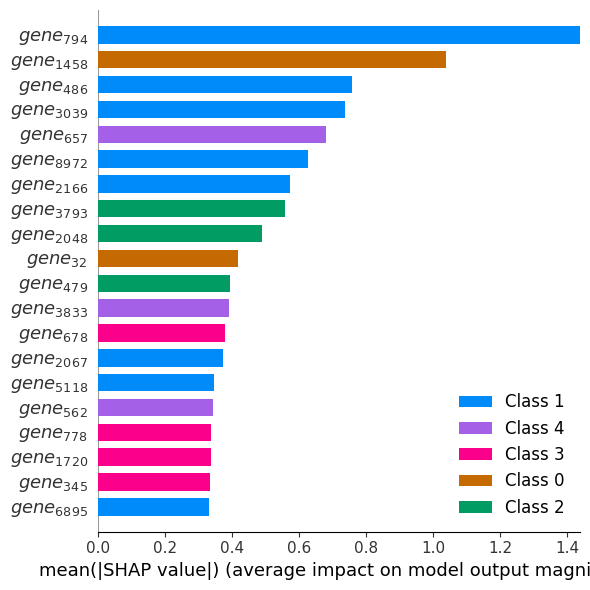

In [292]:
shap.summary_plot(
    shap_values, x_te, 
    show=False,
    plot_type="bar",
    plot_size=(6, 6)
)

# Schemmatics

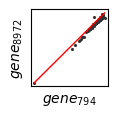

In [46]:
fig, ax = plt.subplots(figsize=(1, 1))

df = conf.data[
    conf.data.obs["leiden"] == "Cluster-A",
    get_deg(conf.data, "Cluster-A", min_logfc=1)[:2]
].to_df()

sns.scatterplot(
    data=df,
    x=df.columns[0],
    y=df.columns[1],
    s=5, color=".2", linewidth=0
)

ax.tick_params(
    axis='both', which='both', 
    bottom=False, top=False, left=False, right=False, 
    labelbottom=False, labelleft=False
)

x = np.linspace(df.min(axis=0)[0], df.max(axis=0)[0], 1000)
coef = df.corr().values.ravel()[1]

ax.plot(x, coef * x, c="r", linewidth=1);

fig.savefig(f"{conf.export}/correlation.png", **kwarg_savefig)

In [47]:
df = conf.data[
    conf.data.obs["leiden"] == "Cluster-A",
    get_deg(conf.data, "Cluster-C", min_logfc=1)[:5]
].to_df().iloc[:, [3, 4]]

In [62]:
np.random.seed(0)
arr = df.values
arr = np.where(
    arr >= 4, 1, 0
)
arr = arr + np.random.randn(*arr.shape) / 10

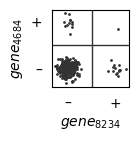

In [63]:
fig, ax = plt.subplots(figsize=(1, 1))

ax.axhline(.5, 0, 1, linewidth=1, c=".2")
ax.axvline(.5, 0, 1, linewidth=1, c=".2")
ax.tick_params(
    axis='both', which='both', 
    bottom=False, top=False, left=False, right=False
)

ax.scatter(arr[:, 0], arr[:, 1], s=1, c=".2")
ax.set(xlabel=df.columns[0], ylabel=df.columns[1])
ax.set_xticklabels(["", "–", "+", ""])
ax.set_yticklabels(["", "–", "+", ""])

fig.savefig(f"{conf.export}/2x2table.png", **kwarg_savefig)